In [2]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN, NullWork
from architectures import FNN, StackedNN, ResNet, count_parameters
from utils import RAD_sampler, sample_collocation_points
from NavierStokesData import NavierStokesData

In [3]:
# Data points
data = NavierStokesData(samplesize=2000)
Zd = data.Zd
Ud = data.Ud

# # Get index of datapoints on the boundary
# idx = (data.Zd_full[:, 0] == 1)
# Zd = data.Zd_full[idx]
# Ud = data.Ud_full[idx]

# # # Get index of initial datapoints
# # idx = (data.Zd_full[:, 2] == 0)
# # Zd = data.Zd_full[idx]
# # Ud = data.Ud_full[idx]

In [4]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 3, [1, -2, 0], [8, 2, 20], method='sobol')

In [5]:
def compute_grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

class NavierStokes(torch.nn.Module):
    def __init__(self, lambda1, lambda2):
        super(NavierStokes, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2


    def forward(self, Z, U):

        psi = U[:, 0:1]
        p = U[:, 1:2]

        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        u_z = compute_grad(u, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]
        u_t = u_z[:, 2:3]

        v_z = compute_grad(v, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]
        v_t = v_z[:, 2:3]

        p_z = compute_grad(p, Z)
        p_x = p_z[:, 0:1]
        p_y = p_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        f = u_t + self.lambda1 * (u * u_x + v * u_y) + p_x # - self.lambda2 * (u_xx + u_yy)
        g = v_t + self.lambda1 * (u * v_x + v * v_y) + p_y # - self.lambda2 * (v_xx + v_yy)

        return torch.cat([f, g], dim=1)

lambda1 = 1.0
lambda2 = 0.01

N = NavierStokes(lambda1, lambda2)

In [6]:
class NavierStokesUPINN(UPINN):
    
    def score(self):

        Xtest = data.Zd_full.requires_grad_(True)

        U_pred = self.u(Xtest)
        psi_z = compute_grad(U_pred[:, 0], Xtest)
        psi_y = psi_z[:, 1:2]
        psi_x = psi_z[:, 0:1]

        data_pred = torch.cat([psi_y, -psi_x], dim=1)
        

        RRMSE = torch.sqrt(torch.mean((data_pred - data.Ud_full[:, 0:2])**2)) / torch.sqrt(torch.mean(data.Ud_full[:, 0:2]**2))

        return RRMSE
    

    def score_residual(self):
        
        x_true = np.linspace(1, 8, 100)
        y_true = np.linspace(-2, 2, 50)
        u_true = data.Ud_full[:, 0].reshape(50,100)
        v_true = data.Ud_full[:, 1].reshape(50,100)

        # True residual
        u_x = np.gradient(u_true, x_true, axis=1)
        u_y = np.gradient(u_true, y_true, axis=0)

        v_x = np.gradient(v_true, x_true, axis=1)
        v_y = np.gradient(v_true, y_true, axis=0)

        u_xx = np.gradient(u_x, x_true, axis=1)
        u_yy = np.gradient(u_y, y_true, axis=0)

        v_xx = np.gradient(v_x, x_true, axis=1)
        v_yy = np.gradient(v_y, y_true, axis=0)

        res_true_f = - lambda2 * (u_xx + u_yy)
        res_true_g = - lambda2 * (v_xx + v_yy)

        res_true = np.concatenate([res_true_f.reshape(-1,1), res_true_g.reshape(-1,1)], axis=1)

        z_test = torch.tensor(np.array(np.meshgrid(x_true, y_true)).T.reshape(-1,2)).float()
        u_test = self.u(z_test)
        res_pred = self.N(z_test, u_test).detach().numpy()
        res_pred = res_pred.reshape(50,100,2)

        residual_loss = np.mean((res_true - res_pred)**2)

        return residual_loss
        


    def data_loss(self):

        if self.data_points is not None:
            
            self.data_points[0].requires_grad_(True)

            Ud = self.u(self.data_points[0])

            psi_z = compute_grad(Ud[:, 0], self.data_points[0])
            psi_y = psi_z[:, 1:2]
            psi_x = psi_z[:, 0:1]

            # data_pred = torch.cat([psi_y, -psi_x], dim=1)
            # data_loss = torch.mean((data_pred - self.data_points[1][:, 0:2])**2)

            data_pred = torch.cat([psi_y, -psi_x, Ud[:, 1:2]], dim=1)
            data_loss = torch.mean((data_pred - self.data_points[1][:, 0:3])**2)

            # self.log.setdefault("lambda1", []).append(lambda1.item())
            # self.log.setdefault("lambda2", []).append(lambda2.item())

        else: data_loss = torch.tensor(0.0)

        return data_loss
    
    def F_input(self, Z, U):
        
        psi = U[:, 0:1]
        
        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        return torch.cat([Z, u, v], dim=1)


    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sample_collocation_points(N, 3, lb=[1, -2, 0], ub=[8, 2, 20], method='sobol').requires_grad_(True)

        # Compute the residual
        U = self.u(Xc)
        residual = torch.sum(torch.abs(self.F(self.F_input(Xc, U)) + self.N(Xc, U)), dim=1)

        self.collocation_points = RAD_sampler(Xc, residual, D, k, c) # RAD
    


In [ ]:
hidden = [20] * 8

u = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[5, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [8]:
# u = ResNet(
#     input_dim=3, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
# )

# F = ResNet(
#     input_dim=5, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
# )

In [9]:
# u1 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u2 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u = StackedNN([u1, u2])

# F1 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F2 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F = StackedNN([F1, F2])

In [10]:
# hidden = [4] * 4

# u = KAN([3, *hidden, 2])
# F = KAN([5, *hidden, 2])

In [ ]:
model = NavierStokesUPINN(u, N, F, data_points=(Zd, Ud), collocation_points=Xc)
model.inductive_bias = False

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [17]:
# name = 'ns-upinn-inviscid-5000' # 01
# name = 'ns-upinn-with-pressuredata-plain-2000' # 03
# name = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000' # 04
# name = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000'
name = 'ns-pinn-reverse'
model.load(name, 'models')

In [677]:
name = '04'
save = False

In [678]:
plot_data = data.get_quantities(model, t=10)

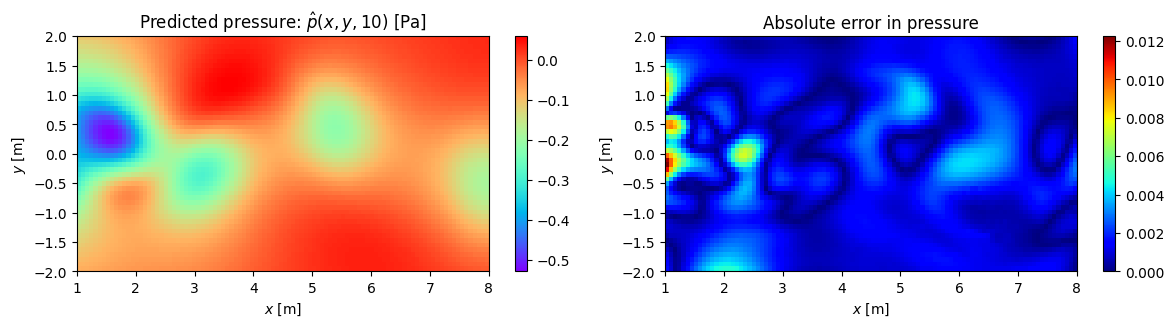

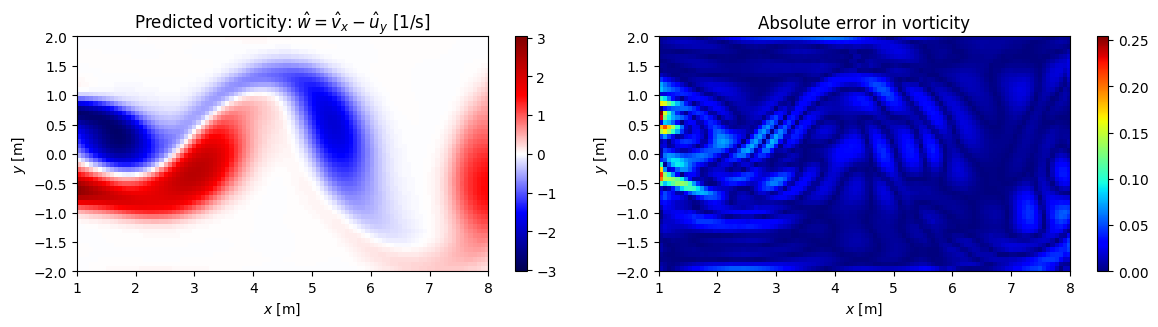

In [679]:

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['p_pred'], extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted pressure: $\hat{p}(x, y, 10)$ [Pa]')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['p_true']-plot_data['p_pred']), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error in pressure')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-pressure_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()



plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['omega_pred'])), np.max(abs(plot_data['omega_true'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['omega_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted vorticity: $\hat{w} = \hat{v}_x - \hat{u}_y$ [1/s]')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['omega_true']-plot_data['omega_pred']), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error in vorticity')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-vorticity_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()


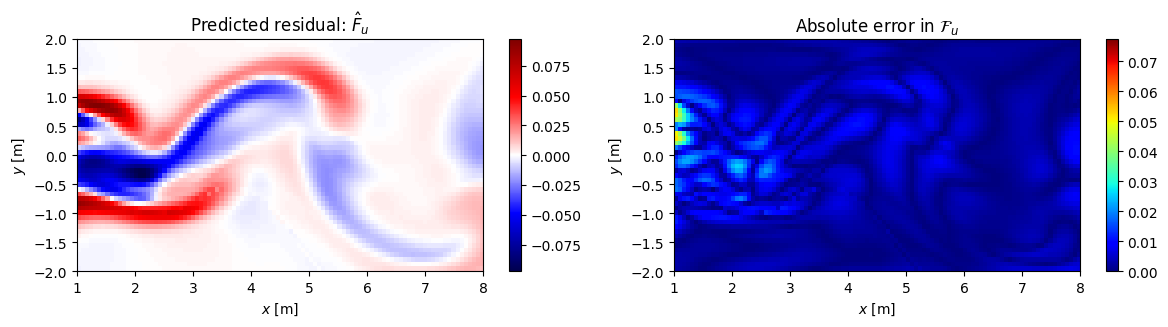

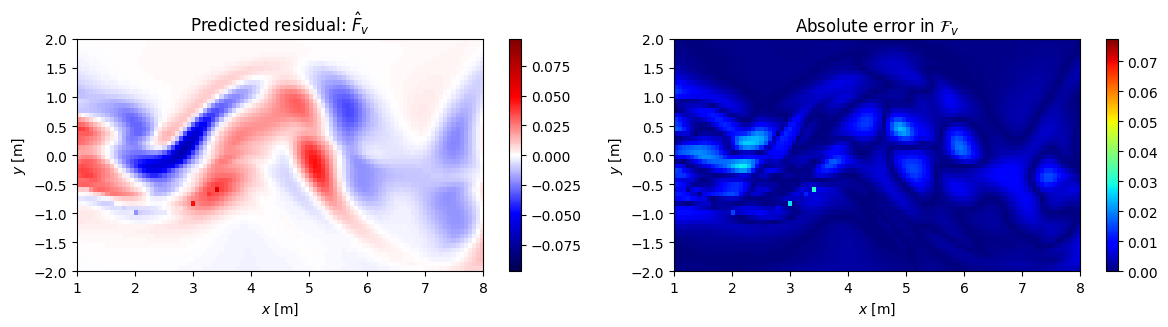

In [681]:
plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['f_res_pred'])), np.max(abs(plot_data['g_res_pred'])))
w = max(np.max(abs(plot_data['f_res_true']-plot_data['f_res_pred'])), np.max(abs(plot_data['g_res_true']-plot_data['g_res_pred'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['f_res_exp']-plot_data['f_res_pred']), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0, vmax=w)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error in $\mathcal{F}_u$')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-f_res_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()



plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['g_res_exp']-plot_data['g_res_pred']), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0, vmax=w)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error in $\mathcal{F}_v$')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-g_res_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()


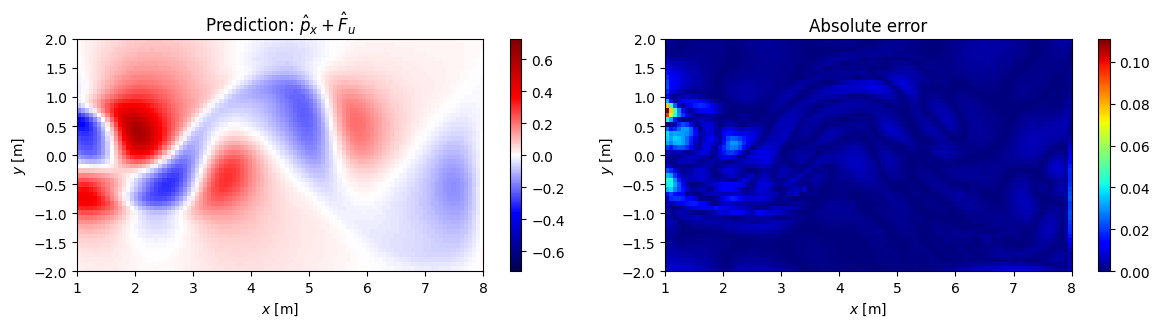

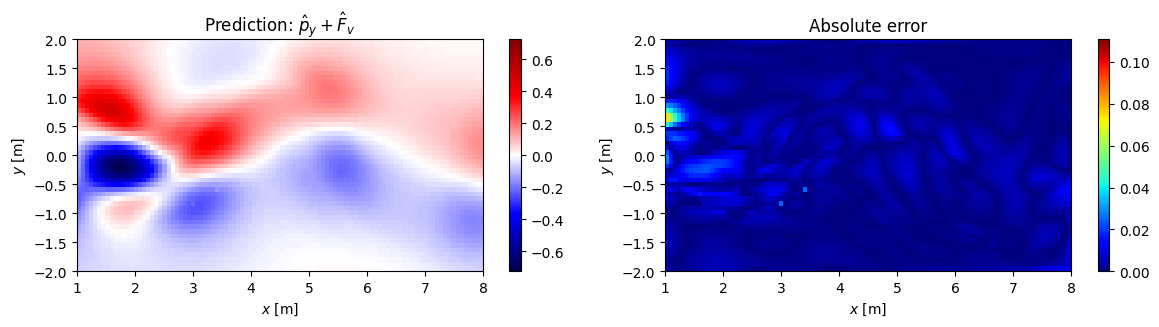

In [682]:
v = max(np.max(abs(plot_data['px_pred']+plot_data['f_res_pred'])), np.max(abs(plot_data['py_pred']+plot_data['g_res_pred'])), np.max(abs(plot_data['px_true']+plot_data['f_res_true'])), np.max(abs(plot_data['py_true']+plot_data['g_res_true'])))
w = max(np.max(abs(plot_data['px_true']+plot_data['f_res_true']-(plot_data['px_pred']+plot_data['f_res_pred']))), np.max(abs(plot_data['py_true']+plot_data['g_res_true']-(plot_data['py_pred']+plot_data['g_res_pred']))))



plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['px_pred'] + plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_x + \hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['px_true'] + plot_data['f_res_true']-(plot_data['px_pred'] + plot_data['f_res_pred'])), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0, vmax=w)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-respred_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['py_pred'] + plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_y + \hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(abs(plot_data['py_true'] + plot_data['g_res_true']-(plot_data['py_pred'] + plot_data['g_res_pred'])), extent=(1, 8, -2, 2), cmap='jet', origin='lower', vmin=0, vmax=w)
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$y$ [m]')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Absolute error')

plt.tight_layout()
if save: plt.savefig('gfx/ns-upinn-restrue_'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
f_res_mse = 0
g_res_mse = 0
u_res_mse = 0
v_res_mse = 0
u_true_mse = 0
v_true_mse = 0
f_true_mse = 0
g_true_mse = 0

for t in data.Zd_full[:, 2].unique().numpy():
    temp = data.get_quantities(model, t=t)
    f_res_mse += np.mean((temp['f_res_pred'] - temp['f_res_exp'])**2)
    g_res_mse += np.mean((temp['g_res_pred'] - temp['g_res_exp'])**2)
    u_res_mse += np.mean((temp['u_pred'] - temp['u_true'].numpy())**2)
    u_true_mse += np.mean(temp['u_true'].numpy()**2)
    v_res_mse += np.mean((temp['v_pred'] - temp['v_true'].numpy())**2)
    v_true_mse += np.mean(temp['v_true'].numpy()**2)
    f_true_mse += np.mean((temp['f_res_exp'])**2)
    g_true_mse += np.mean((temp['g_res_exp'])**2)

u_res_mse += v_res_mse
u_true_mse += v_true_mse

rel_error_u = np.sqrt(u_res_mse / u_true_mse)
rel_error_f = np.sqrt(f_res_mse / f_true_mse)
rel_error_g = np.sqrt(g_res_mse / g_true_mse)
rel_error = np.sqrt((f_res_mse + g_res_mse) / (f_true_mse + g_true_mse))

print(f'rel_error_u: {rel_error_u:.2e}')
print(f'rel_error_f: {rel_error_f:.2e}')
print(f'rel_error_g: {rel_error_g:.2e}')
print(f'rel_error: {rel_error:.2e}')


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.1
14.2
14.3
14.4
14.5
14.6
14.7
14.8
14.9
15.0
15.1
15.2
15.3
15.4
15.5
15.6
15.7
15.8
15.9
16.0
16.1
16.2
16.3
16.4
16.5
16.6
16.7
16.8
16.9
17.0
17.1
17.2
17.3
17.4
17.5
17.6
17.7
17.8
17.9
18.0
18.1
18.2
18.3
18.4
18.5
18.6
18.7
18.8
18.9
19.0
19.1
19.2
19.3
19.4
19.5
19.6
19.7
19.8
19.9
rel_error_u: 1.15e-02
rel_error_f: 2.20e+01
rel_error_g: 2.70e+01
rel_error: 2.37e+01


In [684]:
np.sqrt(2.2e-3 / (u_res_mse / len(data.Zd_full[:, 2].unique().detach().numpy())))

14.087491218386642